In [1]:
pip install rebound

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.5/727.5 KB 7.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import rebound
import numpy as np
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.add("Sun")
sim.add("Mimas")
sim.add("Tethys")

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Mimas'... 
Found: Mimas (601) 
Searching NASA Horizons for 'Tethys'... 
Found: Tethys (603) 


In [3]:
os = sim.calculate_orbits()
print("n_i (in rad/days) = %6.3f, %6.3f" % (os[0].n,os[1].n))
print("P_i (in days)     = %6.3f, %6.3f" % (os[0].P,os[1].n))

AttributeError: 'Simulation' object has no attribute 'calculate_orbits'

In [4]:
sim.integrator = "whfast"
sim.dt = 1. # in years.  About 10% of Jupiter's period
sim.move_to_com()

In [5]:
Nout = 100000
tmax = 3.e5
Nplanets = 2

x = np.zeros((Nplanets,Nout))
ecc = np.zeros((Nplanets,Nout))
longitude = np.zeros((Nplanets,Nout))
varpi = np.zeros((Nplanets,Nout))

times = np.linspace(0.,tmax,Nout)
ps = sim.particles

for i,time in enumerate(times):
    sim.integrate(time) 
    # note we used above the default exact_finish_time = 1, which changes the timestep near the outputs to match
    # the output times we want.  This is what we want for a Fourier spectrum, but technically breaks WHFast's
    # symplectic nature.  Not a big deal here.
    os = sim.calculate_orbits()
    for j in range(Nplanets):
        x[j][i] = ps[j+1].x  # we use the 0 index in x for Jup and 1 for Sat, but the indices for ps start with the Sun at 0
        ecc[j][i] = os[j].e
        longitude[j][i] = os[j].l
        varpi[j][i] = os[j].Omega + os[j].omega

AttributeError: 'Simulation' object has no attribute 'calculate_orbits'

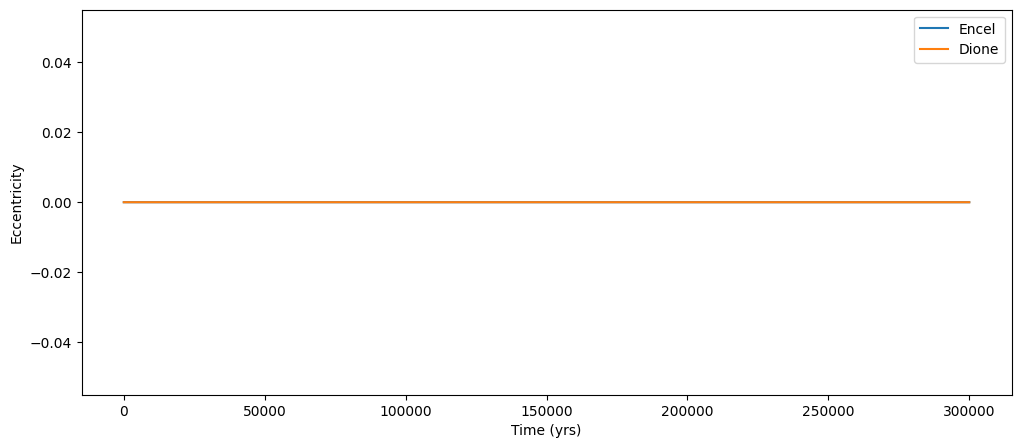

In [6]:
%matplotlib inline
labels = ["Encel", "Dione"]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,ecc[0],label=labels[0])
plt.plot(times,ecc[1],label=labels[1])
ax.set_xlabel("Time (yrs)")
ax.set_ylabel("Eccentricity")
plt.legend();

Text(0, 0.5, 'Power')

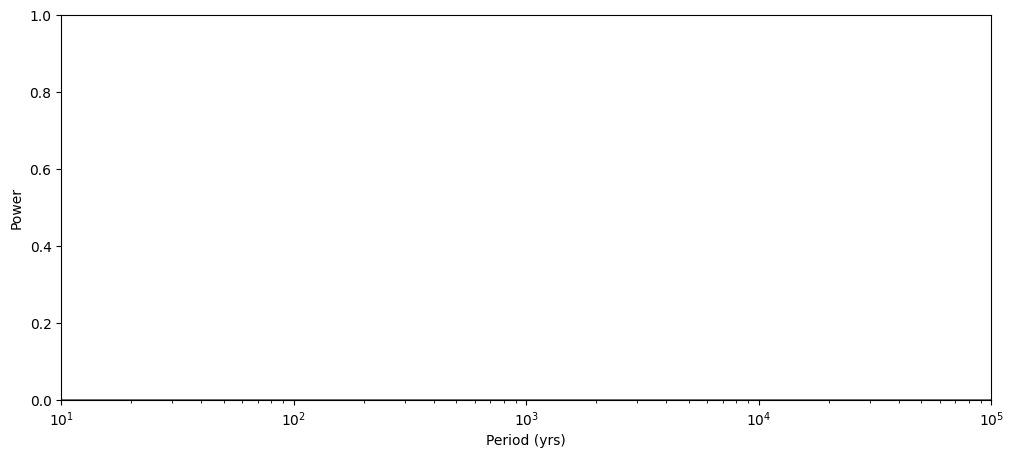

In [7]:
from scipy import signal
Npts = 3000
logPmin = np.log10(10.)
logPmax = np.log10(1.e5)
Ps = np.logspace(logPmin,logPmax,Npts)
ws = np.asarray([2*np.pi/P for P in Ps])

periodogram = signal.lombscargle(times,x[0],ws)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(Ps,np.sqrt(4*periodogram/Nout))
ax.set_xscale('log')
ax.set_xlim([10**logPmin,10**logPmax])
ax.set_ylim([0,1.0])
ax.set_xlabel("Period (yrs)")
ax.set_ylabel("Power")

Text(0, 0.5, 'Power')

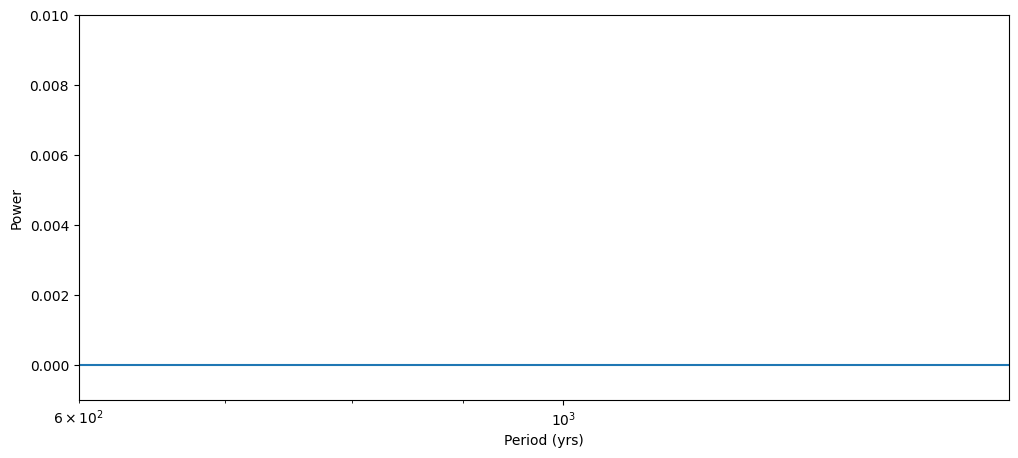

In [8]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(Ps,np.sqrt(4*periodogram/Nout))
ax.set_xscale('log')
ax.set_xlim([600,1600])
ax.set_ylim([-0.001,0.01])
ax.set_xlabel("Period (yrs)")
ax.set_ylabel("Power")

Text(0, 0.5, '$\\phi_{4:2}$')

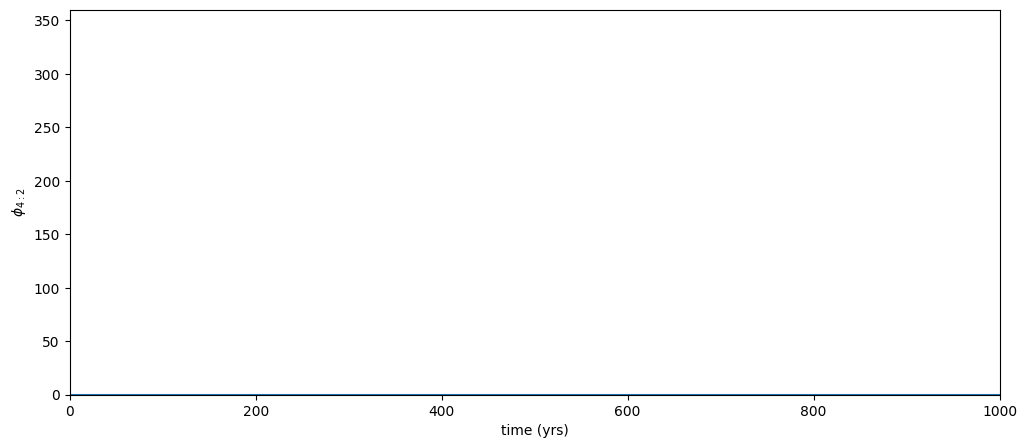

In [9]:
def zeroTo360(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val*180/np.pi

phi = [zeroTo360(4.*longitude[1][i] - 2.*longitude[0][i] - 3.*varpi[0][i]) for i in range(Nout)]
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,phi)
ax.set_xlim([0,1.e3])
ax.set_ylim([0,360.])
ax.set_xlabel("time (yrs)")
ax.set_ylabel(r"$\phi_{4:2}$")

Text(0, 0.5, '$\\phi_{2:1}$')

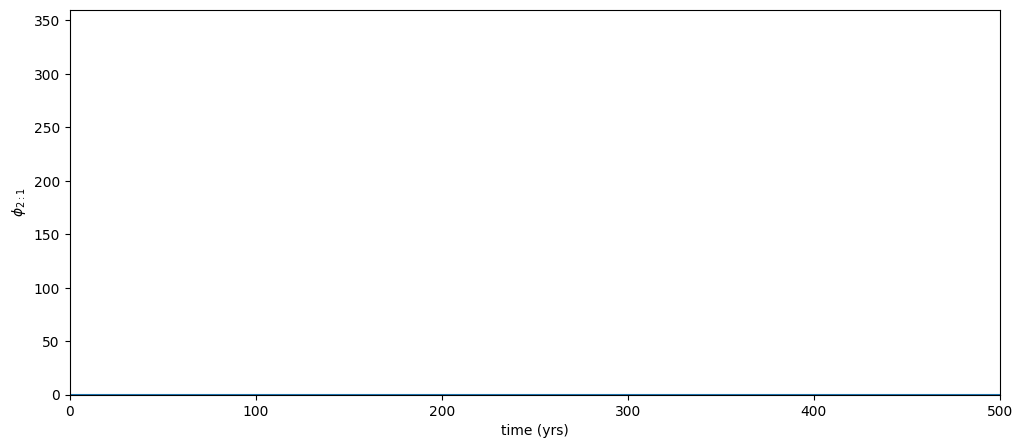

In [10]:
phi2 = [zeroTo360(2*longitude[1][i] - longitude[0][i] - varpi[0][i]) for i in range(Nout)]
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,phi2)
ax.set_xlim([0,5.e2])
ax.set_ylim([0,360.])
ax.set_xlabel("time (yrs)")
ax.set_ylabel(r"$\phi_{2:1}$")